<a href="https://colab.research.google.com/github/peterbabulik/QuantumWalker/blob/main/QuantumWalker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install cirq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.7/192.7 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.0 MB/s eta 0:00:00


Initialized walker at (25, 25) in coin state |00>
Initial state index: 5200
Initial state norm: 1.0000
Coin Operator C_full shape: (10404, 10404)
Shift Operator S_full shape: (10404, 10404)
Step Unitary U_step shape: (10404, 10404)

Starting 2D Quantum Walk evolution for 20 steps...
  Completed step 1/20
  Completed step 5/20
  Completed step 10/20
  Completed step 15/20
  Completed step 20/20
Evolution complete.

Final Probability Distribution Analysis:
  Sum of probabilities P(r,c): 1.000000

--- 2D Quantum Walk Final Probability Distribution ---
Grid = 51x51, Depth = 20
Top 10 Probabilities (Coord: Prob):
  (19,19): 0.05909
  (20,18): 0.04408
  (20,20): 0.03936
  (22,22): 0.03054
  (18,20): 0.02251
  (19,21): 0.02051
  (30,32): 0.01835
  (21,17): 0.01748
  (19,17): 0.01598
  (35,15): 0.01552
--- End of Summary ---


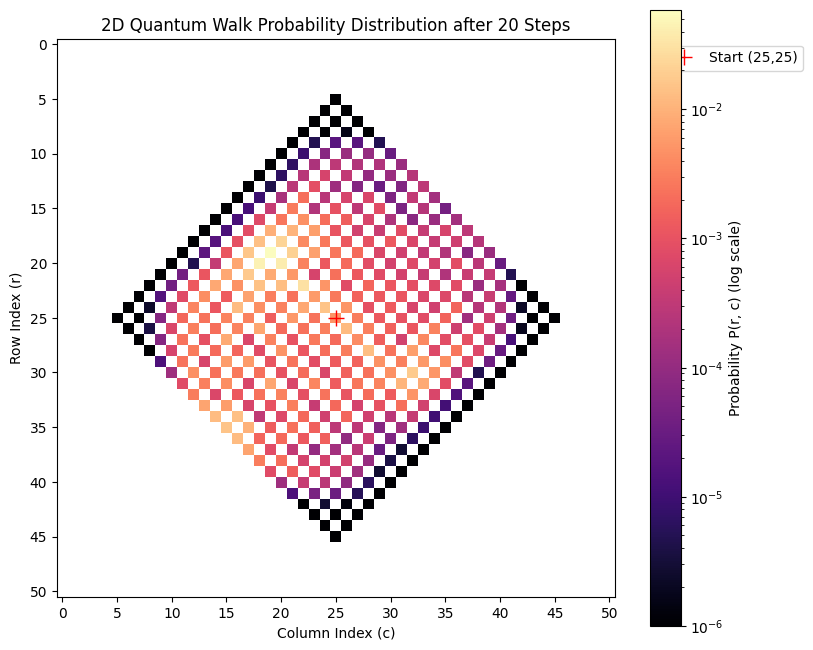

In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# --- Parameters ---
ROWS = 51        # Number of rows (odd for a center)
COLS = 51        # Number of columns (odd for a center)
N_SITES = ROWS * COLS
DEPTH = 20       # Number of steps - Keep relatively low initially for speed/viz
STATE_DIM = 4 * N_SITES # 4 coin states (2 qubits) per site

# --- Helper Function for State Vector Index ---
def get_index(cx, cy, r, c, rows, cols):
    """Maps (cx, cy, r, c) to state vector index k."""
    if not (0 <= cx <= 1 and 0 <= cy <= 1 and 0 <= r < rows and 0 <= c < cols):
        raise ValueError("Invalid coordinates or coin state")
    # Ordering: cx is fastest, then cy, then c, then r (cx is LSB conceptually)
    return cx + 2*cy + 4*c + 4*cols*r

def get_coords_from_index(k, rows, cols):
    """Maps state vector index k back to (cx, cy, r, c)."""
    cx = k % 2
    cy = (k // 2) % 2
    c = (k // 4) % cols
    r = k // (4 * cols)
    return cx, cy, r, c

# --- Initial State ---
initial_state_vector = np.zeros(STATE_DIM, dtype=np.complex128)
center_r = ROWS // 2
center_c = COLS // 2
# Start in state |00, center_r, center_c>
start_index = get_index(0, 0, center_r, center_c, ROWS, COLS)
initial_state_vector[start_index] = 1.0

print(f"Initialized walker at ({center_r}, {center_c}) in coin state |00>")
print(f"Initial state index: {start_index}")
print(f"Initial state norm: {np.linalg.norm(initial_state_vector):.4f}")

# --- Build Unitary Matrices ---

# 1. Coin Operator (Hadamard on both coin qubits at each site)
H = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=np.complex128)
H2 = np.kron(H, H) # Unitary for H⊗H on the 4 coin states
I_sites = np.eye(N_SITES, dtype=np.complex128)
# C = H2 kron I_sites (if basis |coin>@|pos>)
# C = I_sites kron H2 (if basis |pos>@|coin>)
# Our basis index k=cx+2cy+4c+4*COLS*r groups coin states together for each site.
# So we need I_sites kron H2
C_full = np.kron(I_sites, H2)
print(f"Coin Operator C_full shape: {C_full.shape}") # Should be (4N x 4N)

# 2. Shift Operator (Conditional on coin state)
# S|00, r, c> -> |00, r, c-1> (West)
# S|10, r, c> -> |10, r, c+1> (East) - cx=1 means move right
# S|01, r, c> -> |01, r-1, c> (North) - cy=1 means move up (decrease r)
# S|11, r, c> -> |11, r+1, c> (South) - cy=1 means move down (increase r)
# Using Periodic Boundary Conditions
S_full = np.zeros((STATE_DIM, STATE_DIM), dtype=np.complex128)

for k_in in range(STATE_DIM): # Input basis state index
    cx, cy, r, c = get_coords_from_index(k_in, ROWS, COLS)

    r_new, c_new = r, c # Start with current position

    # Determine target position based on coin state (cx, cy)
    if cx == 0 and cy == 0: # West
        c_new = (c - 1 + COLS) % COLS
    elif cx == 1 and cy == 0: # East
        c_new = (c + 1) % COLS
    elif cx == 0 and cy == 1: # North (assuming row 0 is top)
        r_new = (r - 1 + ROWS) % ROWS
    elif cx == 1 and cy == 1: # South
        r_new = (r + 1) % ROWS

    # The coin state itself doesn't change during the shift
    k_out = get_index(cx, cy, r_new, c_new, ROWS, COLS)

    S_full[k_out, k_in] = 1.0

print(f"Shift Operator S_full shape: {S_full.shape}")

# 3. Full Step Unitary
U_step = S_full @ C_full
print(f"Step Unitary U_step shape: {U_step.shape}")

# Check unitarity (optional, can be slow)
# print("Checking if U_step is unitary...")
# diff_unitary = np.linalg.norm(U_step.conj().T @ U_step - np.eye(STATE_DIM))
# print(f"  Norm of (U_dagger U - I): {diff_unitary:.2e}")

# --- Evolution Loop ---
current_state = initial_state_vector.copy()
# state_history = [current_state.copy()] # Not storing history for now

print(f"\nStarting 2D Quantum Walk evolution for {DEPTH} steps...")
for step in range(DEPTH):
    current_state = U_step @ current_state
    # Optional: Normalize
    norm = np.linalg.norm(current_state)
    if np.abs(norm-1.0)>1e-6: current_state /= norm
    # state_history.append(current_state.copy())

    if (step + 1) % 5 == 0 or step == 0 or step == DEPTH-1: # Print progress
         print(f"  Completed step {step + 1}/{DEPTH}")
print("Evolution complete.")

# --- Analysis ---
final_state = current_state

# Calculate Probability Distribution P(r, c) = Sum_{cx,cy} |alpha(cx, cy, r, c)|^2
prob_dist_2d = np.zeros((ROWS, COLS))
for r in range(ROWS):
    for c in range(COLS):
        prob_site = 0.0
        for cx in range(2):
            for cy in range(2):
                idx = get_index(cx, cy, r, c, ROWS, COLS)
                amp = final_state[idx]
                prob_site += np.abs(amp)**2
        prob_dist_2d[r, c] = prob_site

print("\nFinal Probability Distribution Analysis:")
final_sum_prob = np.sum(prob_dist_2d)
print(f"  Sum of probabilities P(r,c): {final_sum_prob:.6f}")
if np.abs(final_sum_prob - 1.0) > 1e-6:
    print("  WARNING: Total probability deviates significantly from 1.0!")


# --- Generate Text Output (Simplified) ---
def generate_2d_qw_text_output(prob_dist_2d, rows, cols, depth):
    output_lines = []
    output_lines.append("\n--- 2D Quantum Walk Final Probability Distribution ---")
    output_lines.append(f"Grid = {rows}x{cols}, Depth = {depth}")
    output_lines.append("Top 10 Probabilities (Coord: Prob):")

    # Find indices of top probabilities
    flat_probs = prob_dist_2d.flatten()
    # Get indices that would sort the array in descending order
    sorted_indices_flat = np.argsort(flat_probs)[::-1]

    count = 0
    for idx_flat in sorted_indices_flat:
        if count >= 10: break
        r = idx_flat // cols
        c = idx_flat % cols
        prob = flat_probs[idx_flat]
        if prob > 1e-6: # Only show if probability is significant
            output_lines.append(f"  ({r},{c}): {prob:.5f}")
            count += 1

    output_lines.append("--- End of Summary ---")
    return "\n".join(output_lines)

# Generate and print the text output
qw_text_summary = generate_2d_qw_text_output(prob_dist_2d, ROWS, COLS, DEPTH)
print(qw_text_summary)

# --- Plotting ---
plt.figure(figsize=(9, 8))
norm = colors.LogNorm(vmin=np.maximum(1e-6, prob_dist_2d.min()), vmax=prob_dist_2d.max()) # Use LogNorm for better visibility of small probs
im = plt.imshow(prob_dist_2d, cmap='magma', norm=norm, origin='upper', interpolation='nearest') # 'upper' for matrix indexing

plt.colorbar(im, label='Probability P(r, c) (log scale)')
plt.title(f"2D Quantum Walk Probability Distribution after {DEPTH} Steps")
plt.xlabel("Column Index (c)")
plt.ylabel("Row Index (r)")

# Set ticks to match grid indices
plt.xticks(np.arange(COLS))
plt.yticks(np.arange(ROWS))
# Show fewer ticks if grid is large
if COLS > 10: plt.xticks(np.linspace(0, COLS-1, min(COLS, 11), dtype=int))
if ROWS > 10: plt.yticks(np.linspace(0, ROWS-1, min(ROWS, 11), dtype=int))

# Mark center
plt.plot(center_c, center_r, 'r+', markersize=12, label=f'Start ({center_r},{center_c})')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))

plt.show()

Initialized walker at (10, 10) in coin state |00>
Initial state index: 880
Initial state norm: 1.0000
Coin Operator C_full shape: (1764, 1764)
Shift Operator S_full shape: (1764, 1764)
Step Unitary U_step shape: (1764, 1764)

Starting 2D Quantum Walk evolution for 1000 steps...
  Completed step 1/1000
  Completed step 5/1000
  Completed step 10/1000
  Completed step 15/1000
  Completed step 20/1000
  Completed step 25/1000
  Completed step 30/1000
  Completed step 35/1000
  Completed step 40/1000
  Completed step 45/1000
  Completed step 50/1000
  Completed step 55/1000
  Completed step 60/1000
  Completed step 65/1000
  Completed step 70/1000
  Completed step 75/1000
  Completed step 80/1000
  Completed step 85/1000
  Completed step 90/1000
  Completed step 95/1000
  Completed step 100/1000
  Completed step 105/1000
  Completed step 110/1000
  Completed step 115/1000
  Completed step 120/1000
  Completed step 125/1000
  Completed step 130/1000
  Completed step 135/1000
  Completed ste

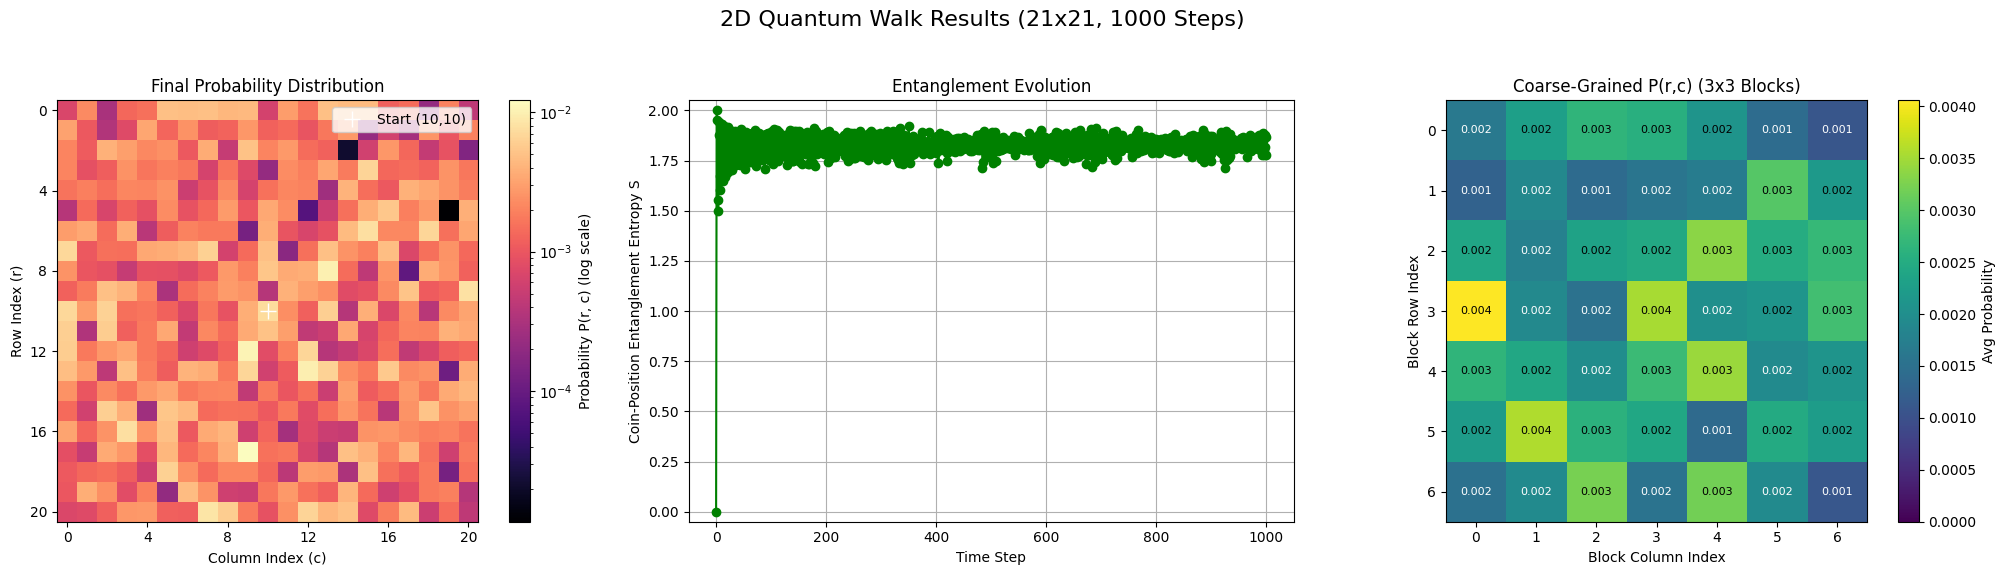


2D Quantum Walk Simulation Finished.


In [6]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# --- Parameters ---
ROWS = 21        # Number of rows (odd for a center)
COLS = 21        # Number of columns (odd for a center)
N_SITES = ROWS * COLS
DEPTH = 1000       # Number of steps - Keep relatively low initially for speed/viz
STATE_DIM = 4 * N_SITES # 4 coin states (2 qubits) per site
INITIAL_STATE_COORDS = (ROWS // 2, COLS // 2) # Center qubit

# --- Helper Function for State Vector Index ---
def get_index(cx, cy, r, c, rows, cols):
    """Maps (cx, cy, r, c) to state vector index k."""
    if not (0 <= cx <= 1 and 0 <= cy <= 1 and 0 <= r < rows and 0 <= c < cols):
        raise ValueError(f"Invalid coords/coin: cx={cx}, cy={cy}, r={r}, c={c} for grid {rows}x{cols}")
    return cx + 2*cy + 4*c + 4*cols*r

def get_coords_from_index(k, rows, cols):
    """Maps state vector index k back to (cx, cy, r, c)."""
    n_sites = rows*cols
    state_dim = 4*n_sites
    if not 0 <= k < state_dim:
         raise ValueError(f"Index k={k} out of bounds for state_dim={state_dim}")
    cx = k % 2
    cy = (k // 2) % 2
    c = (k // 4) % cols
    r = k // (4 * cols)
    return cx, cy, r, c

# --- Initial State Preparation ---
def prepare_initial_state(initial_state_vector, rows, cols, initial_coords):
    r_init, c_init = initial_coords
    start_index = get_index(0, 0, r_init, c_init, rows, cols) # Start in |00> coin state
    initial_state_vector[start_index] = 1.0
    print(f"Initialized walker at ({r_init}, {c_init}) in coin state |00>")
    print(f"Initial state index: {start_index}")
    print(f"Initial state norm: {np.linalg.norm(initial_state_vector):.4f}")


# --- Build Unitary Matrices ---
def build_qw_unitaries(rows, cols):
    n_sites = rows * cols
    state_dim = 4 * n_sites

    H = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=np.complex128)
    H2 = np.kron(H, H)
    I_sites = np.eye(n_sites, dtype=np.complex128)
    C_full = np.kron(I_sites, H2)
    print(f"Coin Operator C_full shape: {C_full.shape}")

    S_full = np.zeros((state_dim, state_dim), dtype=np.complex128)
    for k_in in range(state_dim):
        cx, cy, r, c = get_coords_from_index(k_in, rows, cols)
        r_new, c_new = r, c
        if cx == 0 and cy == 0: c_new = (c - 1 + cols) % cols  # West
        elif cx == 1 and cy == 0: c_new = (c + 1) % cols       # East
        elif cx == 0 and cy == 1: r_new = (r - 1 + rows) % rows # North
        elif cx == 1 and cy == 1: r_new = (r + 1) % rows       # South
        k_out = get_index(cx, cy, r_new, c_new, rows, cols)
        S_full[k_out, k_in] = 1.0
    print(f"Shift Operator S_full shape: {S_full.shape}")

    U_step = S_full @ C_full
    print(f"Step Unitary U_step shape: {U_step.shape}")

    return U_step


# --- Observable Calculation Functions ---
def calculate_p1_position_2d(state_vector, rows, cols):
    num_sites = rows * cols
    state_dim = 4 * num_sites
    if len(state_vector) != state_dim:
         raise ValueError(f"State vector length {len(state_vector)} does not match expected {state_dim}")

    prob_dist_2d = np.zeros((rows, cols))
    for r in range(rows):
        for c in range(cols):
            prob_site = 0.0
            for cx in range(2):
                for cy in range(2):
                    idx = get_index(cx, cy, r, c, rows, cols)
                    amp = state_vector[idx]
                    prob_site += np.abs(amp)**2
            prob_dist_2d[r, c] = prob_site
    return prob_dist_2d

# Corrected Coin Entropy calculation
def calculate_coin_entropy(state_vector, n_sites, rows, cols): # Added rows, cols
    state_dim = 4 * n_sites
    if len(state_vector) != state_dim:
        raise ValueError(f"State vector length mismatch. Expected {state_dim}, got {len(state_vector)}")

    norm = np.linalg.norm(state_vector)
    if np.abs(norm - 1.0) > 1e-6:
        state_vector = state_vector / norm

    rho_coin_4x4 = np.zeros((4, 4), dtype=np.complex128)
    for p in range(n_sites): # Sum over linear site index p
        r, c = p // cols, p % cols # Calculate r, c correctly

        for c1 in range(4): # row index 0..3
            cx1, cy1 = c1%2, (c1//2)%2
            idx_k = get_index(cx1, cy1, r, c, rows, cols) # Use calculated r, c

            for c2 in range(4): # col index 0..3
                cx2, cy2 = c2%2, (c2//2)%2
                idx_l = get_index(cx2, cy2, r, c, rows, cols) # Use calculated r, c

                rho_coin_4x4[c1, c2] += state_vector[idx_k] * np.conjugate(state_vector[idx_l])

    trace_rho_coin = np.trace(rho_coin_4x4)
    if np.abs(trace_rho_coin - 1.0) > 1e-6:
         pass # print(f"Warning: Trace of rho_coin is {trace_rho_coin:.6f}")

    eigenvalues = np.linalg.eigvalsh(rho_coin_4x4)
    entropy = 0.0
    for eig_val in eigenvalues:
        if eig_val > 1e-12:
            entropy -= eig_val * np.log2(eig_val)
        elif eig_val < -1e-12:
             pass # print(f"Warning: Negative eigenvalue in rho_coin: {eig_val:.6e}")

    return np.real(entropy)

# --- Coarse-Graining Function ---
def coarse_grain_probs(prob_grid, block_size_r, block_size_c):
    rows, cols = prob_grid.shape
    crop_rows = (rows // block_size_r) * block_size_r
    crop_cols = (cols // block_size_c) * block_size_c
    if crop_rows != rows or crop_cols != cols:
         print(f"Warning: Cropping grid from {rows}x{cols} to {crop_rows}x{crop_cols} for coarse graining.")
         prob_grid = prob_grid[:crop_rows, :crop_cols]
         rows, cols = crop_rows, crop_cols

    if rows == 0 or cols == 0: return np.array([[]])

    num_blocks_r = rows // block_size_r
    num_blocks_c = cols // block_size_c
    coarse_grained = prob_grid.reshape(num_blocks_r, block_size_r,
                                     num_blocks_c, block_size_c).mean(axis=(1, 3))
    return coarse_grained


# --- Main Simulation Function ---
def run_2d_qw_simulation(
    rows: int,
    cols: int,
    depth: int,
    initial_coords: tuple
) -> dict:
    n_sites = rows * cols
    state_dim = 4 * n_sites

    initial_state_vector = np.zeros(state_dim, dtype=np.complex128)
    prepare_initial_state(initial_state_vector, rows, cols, initial_coords)

    U_step = build_qw_unitaries(rows, cols)

    current_state = initial_state_vector.copy()
    # Pass rows, cols to initial entropy calculation
    coin_entropy_history = [calculate_coin_entropy(current_state, n_sites, rows, cols)]

    print(f"\nStarting 2D Quantum Walk evolution for {depth} steps...")
    for step in range(depth):
        current_state = U_step @ current_state
        norm = np.linalg.norm(current_state)
        if np.abs(norm-1.0)>1e-6: current_state /= norm

        # Pass rows, cols to entropy calculation in loop
        coin_entropy_history.append(calculate_coin_entropy(current_state, n_sites, rows, cols))

        if (step + 1) % 5 == 0 or step == 0 or step == depth-1:
             print(f"  Completed step {step + 1}/{depth}")
    print("Evolution complete.")

    final_state = current_state

    prob_dist_2d = calculate_p1_position_2d(final_state, rows, cols)
    final_sum_prob = np.sum(prob_dist_2d)
    print("\nFinal Probability Distribution Analysis:")
    print(f"  Sum of probabilities P(r,c): {final_sum_prob:.6f}")

    block_r, block_c = 3, 3
    prob_coarse = None
    if rows >= block_r and cols >= block_c:
        prob_coarse = coarse_grain_probs(prob_dist_2d, block_r, block_c)

    results = {
        "prob_dist_2d": prob_dist_2d,
        "prob_coarse": prob_coarse,
        "coin_entropy_history": np.array(coin_entropy_history),
        "params": {
            "rows": rows, "cols": cols, "depth": depth,
            "initial_coords": initial_coords,
            "coarse_block_size": (block_r, block_c) if prob_coarse is not None else None
        }
    }
    return results


# --- Plotting Function ---
# (Omitted for brevity - use previous version)
def plot_2d_qw_results(results_dict: dict):
    params = results_dict["params"]
    prob_dist_2d = results_dict["prob_dist_2d"]
    prob_coarse = results_dict.get("prob_coarse", None)
    coin_entropy_history = results_dict["coin_entropy_history"]
    rows = params["rows"]
    cols = params["cols"]
    depth = params["depth"]
    initial_coords = params["initial_coords"]

    has_coarse_data = prob_coarse is not None
    num_plots = 2 + (1 if has_coarse_data else 0)
    fig, axs = plt.subplots(1, num_plots, figsize=(num_plots * 7, 6))
    fig.suptitle(f"2D Quantum Walk Results ({rows}x{cols}, {depth} Steps)", fontsize=16)

    plot_idx = 0

    # Plot 1: Final Probability Distribution (Heatmap)
    ax_prob = axs[plot_idx] if num_plots > 1 else axs
    min_val = np.maximum(1e-6, prob_dist_2d[prob_dist_2d>0].min())
    max_val = prob_dist_2d.max()
    # Handle case where max_val is close to min_val or zero
    if max_val <= min_val: max_val = min_val + 1e-6
    norm = colors.LogNorm(vmin=min_val, vmax=max_val)
    im = ax_prob.imshow(prob_dist_2d, cmap='magma', norm=norm, origin='upper', interpolation='nearest')
    plt.colorbar(im, ax=ax_prob, label='Probability P(r, c) (log scale)')
    ax_prob.set_title(f"Final Probability Distribution")
    ax_prob.set_xlabel("Column Index (c)")
    ax_prob.set_ylabel("Row Index (r)")
    ax_prob.set_xticks(np.linspace(0, cols-1, min(cols, 6), dtype=int))
    ax_prob.set_yticks(np.linspace(0, rows-1, min(rows, 6), dtype=int))
    ax_prob.plot(initial_coords[1], initial_coords[0], 'w+', markersize=12, label=f'Start ({initial_coords[0]},{initial_coords[1]})') # White cross
    ax_prob.legend(loc='upper right')
    plot_idx += 1

    # Plot 2: Coin-Position Entanglement Entropy vs Time
    ax_ent = axs[plot_idx] if num_plots > 1 else None
    if ax_ent is not None:
        time_axis = np.arange(depth + 1) # 0 to DEPTH
        ax_ent.plot(time_axis, coin_entropy_history, marker='o', linestyle='-', color='green')
        ax_ent.set_xlabel("Time Step")
        ax_ent.set_ylabel("Coin-Position Entanglement Entropy S")
        ax_ent.set_title("Entanglement Evolution")
        ax_ent.grid(True)
        ax_ent.set_ylim(-0.05, 2.05) # Max entropy is log2(4)=2
        plot_idx += 1

    # Plot 3: Coarse-Grained Probability (If available)
    if has_coarse_data:
        ax_cg = axs[plot_idx] if num_plots > 1 else None
        if ax_cg is not None:
            block_r, block_c = params["coarse_block_size"]
            cg_rows, cg_cols = prob_coarse.shape
            # Use linear scale for coarse-grained plot
            max_cg_val = prob_coarse.max()
            if max_cg_val < 1e-9: max_cg_val = 1e-9 # Avoid zero range
            norm_cg = colors.Normalize(vmin=0., vmax=max_cg_val)
            im_cg = ax_cg.imshow(prob_coarse, cmap='viridis', norm=norm_cg, origin='upper', interpolation='nearest')
            plt.colorbar(im_cg, ax=ax_cg, label='Avg Probability')
            ax_cg.set_title(f"Coarse-Grained P(r,c) ({block_r}x{block_c} Blocks)")
            ax_cg.set_xlabel("Block Column Index")
            ax_cg.set_ylabel("Block Row Index")
            ax_cg.set_xticks(np.arange(cg_cols))
            ax_cg.set_yticks(np.arange(cg_rows))
            if cg_rows <= 10 and cg_cols <= 10:
                 for r_cg in range(cg_rows):
                     for c_cg in range(cg_cols):
                         prob_val = prob_coarse[r_cg, c_cg]
                         text_color = "white" if prob_val < 0.5 * max_cg_val else "black"
                         ax_cg.text(c_cg, r_cg, f"{prob_val:.3f}", ha="center", va="center", color=text_color, fontsize=8)
            plot_idx += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Function to Generate Text Summary ---
def generate_2d_qw_text_output(results_dict: dict) -> str:
    params = results_dict["params"]
    prob_dist_2d = results_dict["prob_dist_2d"]
    coin_entropy_history = results_dict["coin_entropy_history"]
    prob_coarse = results_dict.get("prob_coarse", None)
    rows = params["rows"]
    cols = params["cols"]
    depth = params["depth"]
    initial_coords = params["initial_coords"]

    output_lines = []
    output_lines.append("\n--- 2D Quantum Walk Final Probability Distribution & Entanglement ---")
    output_lines.append(f"Grid = {rows}x{cols}, Depth = {depth}, Start = {initial_coords}")
    output_lines.append("Top 10 Probabilities (Coord: Prob):")

    flat_probs = prob_dist_2d.flatten()
    sorted_indices_flat = np.argsort(flat_probs)[::-1]
    count = 0
    for idx_flat in sorted_indices_flat:
        if count >= 10: break
        # Convert flat index back to r, c - NEED COLS
        r = idx_flat // cols
        c = idx_flat % cols
        prob = flat_probs[idx_flat]
        if prob > 1e-6:
            output_lines.append(f"  ({r},{c}): {prob:.5f}")
            count += 1

    output_lines.append("\nCoin-Position Entanglement Entropy vs. Time:")
    num_steps_total = len(coin_entropy_history)
    indices_to_show = [0]
    if num_steps_total > 2: indices_to_show.append(num_steps_total // 2)
    if num_steps_total > 1: indices_to_show.append(num_steps_total - 1)
    indices_to_show = sorted(list(set(indices_to_show)))
    for idx in indices_to_show:
         output_lines.append(f"  Step {idx}: S(coin) = {coin_entropy_history[idx]:.6f}")

    if prob_coarse is not None:
        block_r, block_c = params["coarse_block_size"]
        output_lines.append(f"\nFinal Coarse-Grained P(r,c) ({block_r}x{block_c} blocks):")
        # Limit displayed array size if too large
        max_cg_rows_disp = 15
        max_cg_cols_disp = 15
        rows_to_show = min(prob_coarse.shape[0], max_cg_rows_disp)
        cols_to_show = min(prob_coarse.shape[1], max_cg_cols_disp)
        disp_str = np.array2string(prob_coarse[:rows_to_show, :cols_to_show], precision=4, separator=', ', suppress_small=True)
        if rows_to_show < prob_coarse.shape[0] or cols_to_show < prob_coarse.shape[1]:
             disp_str += "\n  (...truncated...)"
        output_lines.append(disp_str)

    output_lines.append("--- End of Summary ---")
    return "\n".join(output_lines)

# --- Main Execution ---
if __name__ == "__main__":

    simulation_data = run_2d_qw_simulation(
        rows=ROWS,
        cols=COLS,
        depth=DEPTH,
        initial_coords=INITIAL_STATE_COORDS
    )

    qw_text_summary = generate_2d_qw_text_output(simulation_data)
    print(qw_text_summary)

    plot_2d_qw_results(simulation_data)

    print("\n2D Quantum Walk Simulation Finished.")


===== Running 2D QW: Coin = Hadamard =====
Initialized walker at (10, 10) in coin state |00>
Initial state index: 880
Initial state norm: 1.0000
Coin Operator C_full shape: (1764, 1764)
Shift Operator S_full shape: (1764, 1764)
Step Unitary U_step shape: (1764, 1764)

Starting 2D Quantum Walk (Hadamard coin) evolution for 500 steps...
  Completed step 1/500
  Completed step 10/500
  Completed step 20/500
  Completed step 30/500
  Completed step 40/500
  Completed step 50/500
  Completed step 60/500
  Completed step 70/500
  Completed step 80/500
  Completed step 90/500
  Completed step 100/500
  Completed step 110/500
  Completed step 120/500
  Completed step 130/500
  Completed step 140/500
  Completed step 150/500
  Completed step 160/500
  Completed step 170/500
  Completed step 180/500
  Completed step 190/500
  Completed step 200/500
  Completed step 210/500
  Completed step 220/500
  Completed step 230/500
  Completed step 240/500
  Completed step 250/500
  Completed step 260/50

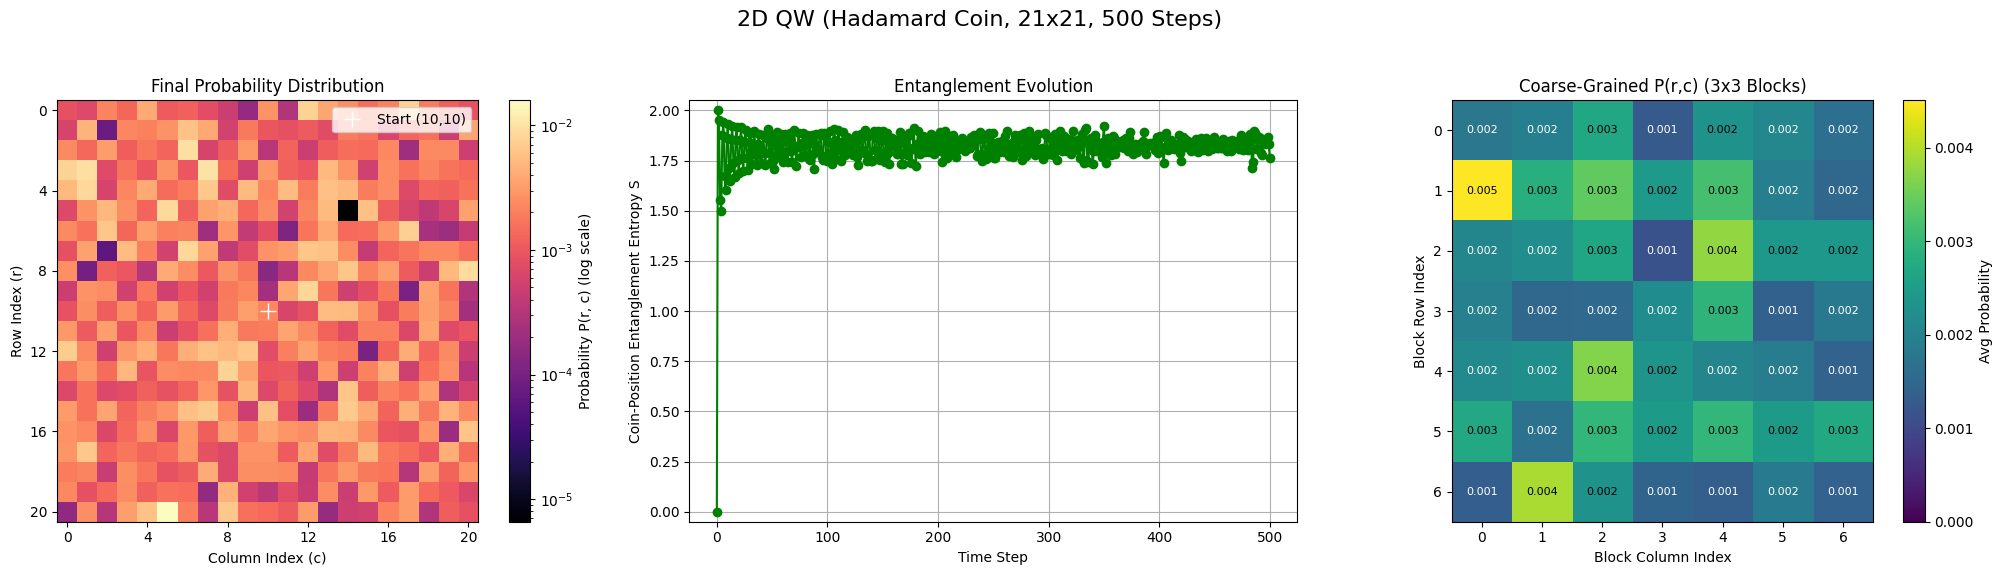

--- Finished simulation for Coin = Hadamard ---

===== Running 2D QW: Coin = Grover =====
Initialized walker at (10, 10) in coin state |00>
Initial state index: 880
Initial state norm: 1.0000
Coin Operator C_full shape: (1764, 1764)
Shift Operator S_full shape: (1764, 1764)
Step Unitary U_step shape: (1764, 1764)

Starting 2D Quantum Walk (Grover coin) evolution for 500 steps...
  Completed step 1/500
  Completed step 10/500
  Completed step 20/500
  Completed step 30/500
  Completed step 40/500
  Completed step 50/500
  Completed step 60/500
  Completed step 70/500
  Completed step 80/500
  Completed step 90/500
  Completed step 100/500
  Completed step 110/500
  Completed step 120/500
  Completed step 130/500
  Completed step 140/500
  Completed step 150/500
  Completed step 160/500
  Completed step 170/500
  Completed step 180/500
  Completed step 190/500
  Completed step 200/500
  Completed step 210/500
  Completed step 220/500
  Completed step 230/500
  Completed step 240/500
  Co

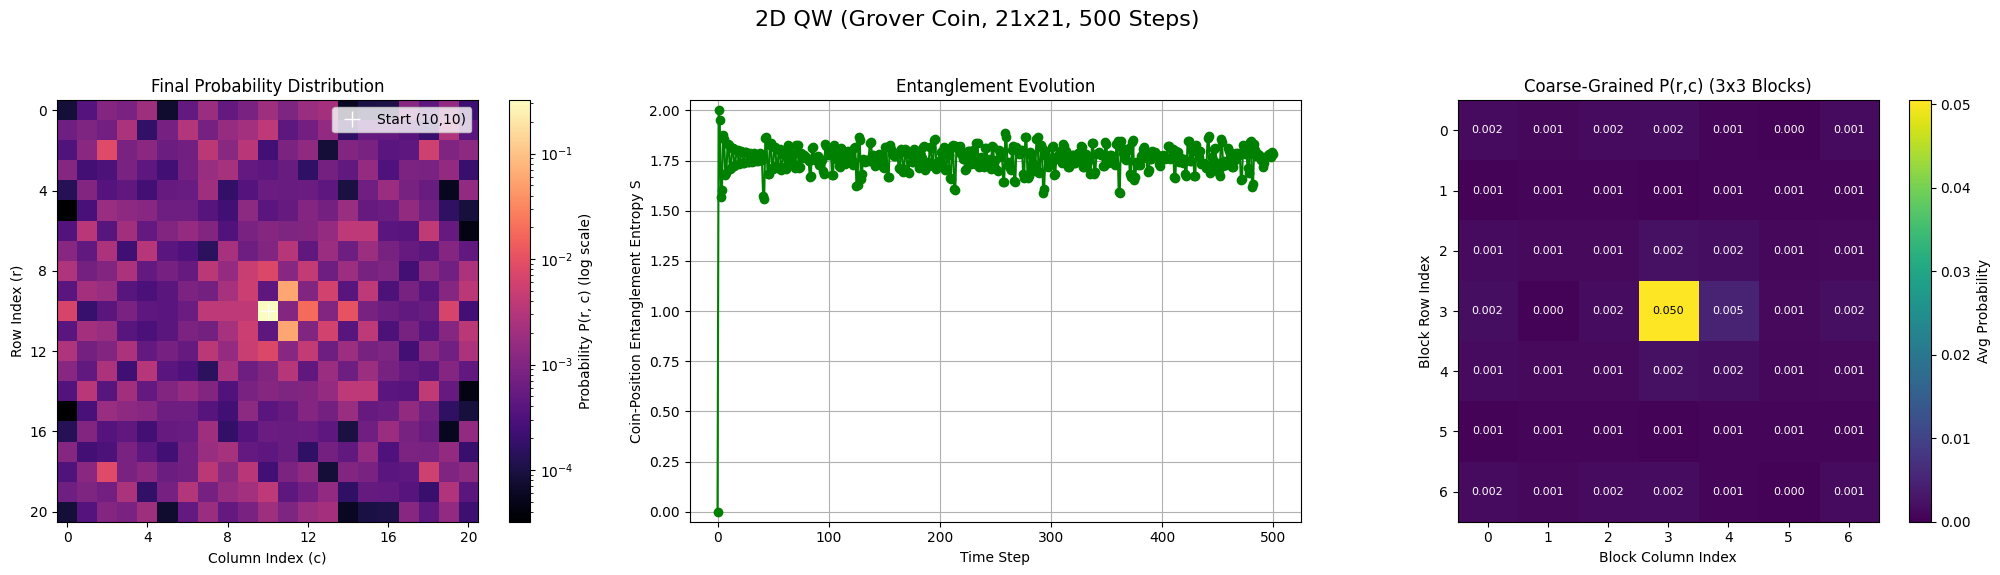

--- Finished simulation for Coin = Grover ---


<<<<< ALL QCA SIMULATION TEXT OUTPUTS (COPY FROM HERE) >>>>>

--- 2D Quantum Walk (Hadamard Coin) Final Probability & Entanglement ---
Grid = 21x21, Depth = 500, Start = (10, 10)
Top 10 Probabilities (Coord: Prob):
  (20,5): 0.01590
  (3,7): 0.01024
  (2,6): 0.00961
  (3,1): 0.00952
  (8,20): 0.00911
  (5,5): 0.00873
  (4,1): 0.00847
  (7,6): 0.00847
  (9,12): 0.00825
  (13,8): 0.00783

Coin-Position Entanglement Entropy vs. Time:
  Step 0: S(coin) = 0.000000
  Step 250: S(coin) = 1.889075
  Step 500: S(coin) = 1.761102

Final Coarse-Grained P(r,c) (3x3 blocks):
[[0.0018, 0.002 , 0.0027, 0.0013, 0.0023, 0.0021, 0.0016],
 [0.0045, 0.0028, 0.0034, 0.0024, 0.0032, 0.0019, 0.0015],
 [0.0021, 0.0022, 0.0026, 0.0011, 0.0038, 0.0024, 0.0024],
 [0.002 , 0.0015, 0.0015, 0.0022, 0.0029, 0.0014, 0.0018],
 [0.0021, 0.0022, 0.0037, 0.0023, 0.002 , 0.0019, 0.0014],
 [0.0027, 0.0017, 0.003 , 0.0025, 0.003 , 0.0025, 0.0027],
 [0.0013, 0.0039, 0.0023, 0.0

In [8]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import random

# --- Parameters ---
ROWS = 21
COLS = 21
N_SITES = ROWS * COLS
DEPTH = 500      # Adjust depth as needed (50 is reasonable for Grover)
STATE_DIM = 4 * N_SITES
INITIAL_STATE_COORDS = (ROWS // 2, COLS // 2)

# --- Helper Function for State Vector Index ---
# (Keep get_index and get_coords_from_index as before)
def get_index(cx, cy, r, c, rows, cols):
    if not (0 <= cx <= 1 and 0 <= cy <= 1 and 0 <= r < rows and 0 <= c < cols):
        raise ValueError(f"Invalid coords/coin: cx={cx}, cy={cy}, r={r}, c={c} for grid {rows}x{cols}")
    return cx + 2*cy + 4*c + 4*cols*r

def get_coords_from_index(k, rows, cols):
    n_sites = rows*cols
    state_dim = 4*n_sites
    if not 0 <= k < state_dim:
         raise ValueError(f"Index k={k} out of bounds for state_dim={state_dim}")
    cx = k % 2
    cy = (k // 2) % 2
    c = (k // 4) % cols
    r = k // (4 * cols)
    return cx, cy, r, c

# --- Define Coin Matrices ---
H = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=np.complex128)
HADAMARD_COIN = np.kron(H, H) # H⊗H

GROVER_COIN = np.full((4, 4), 0.5, dtype=np.complex128) # Start with all 0.5
np.fill_diagonal(GROVER_COIN, -0.5) # Set diagonal to -0.5
# G = [[-0.5,  0.5,  0.5,  0.5],
#      [ 0.5, -0.5,  0.5,  0.5],
#      [ 0.5,  0.5, -0.5,  0.5],
#      [ 0.5,  0.5,  0.5, -0.5]]

# --- Initial State Preparation ---
def prepare_initial_state(initial_state_vector, rows, cols, initial_coords, initial_coin_state=(0,0)):
    r_init, c_init = initial_coords
    cx_init, cy_init = initial_coin_state
    start_index = get_index(cx_init, cy_init, r_init, c_init, rows, cols)
    initial_state_vector[start_index] = 1.0 # Start localized in one basis state
    print(f"Initialized walker at ({r_init}, {c_init}) in coin state |{cx_init}{cy_init}>")
    print(f"Initial state index: {start_index}")
    print(f"Initial state norm: {np.linalg.norm(initial_state_vector):.4f}")


# --- Build Unitary Matrices (Now takes coin_matrix) ---
def build_qw_unitaries(rows, cols, coin_matrix): # Accept coin_matrix
    n_sites = rows * cols
    state_dim = 4 * n_sites

    # Coin Operator
    I_sites = np.eye(n_sites, dtype=np.complex128)
    C_full = np.kron(I_sites, coin_matrix) # Use the provided coin matrix
    print(f"Coin Operator C_full shape: {C_full.shape}")

    # Shift Operator (Same as before)
    S_full = np.zeros((state_dim, state_dim), dtype=np.complex128)
    for k_in in range(state_dim):
        cx, cy, r, c = get_coords_from_index(k_in, rows, cols)
        r_new, c_new = r, c
        if cx == 0 and cy == 0: c_new = (c - 1 + cols) % cols  # West
        elif cx == 1 and cy == 0: c_new = (c + 1) % cols       # East
        elif cx == 0 and cy == 1: r_new = (r - 1 + rows) % rows # North
        elif cx == 1 and cy == 1: r_new = (r + 1) % rows       # South
        k_out = get_index(cx, cy, r_new, c_new, rows, cols)
        S_full[k_out, k_in] = 1.0
    print(f"Shift Operator S_full shape: {S_full.shape}")

    # Full Step Unitary
    U_step = S_full @ C_full
    print(f"Step Unitary U_step shape: {U_step.shape}")

    # Check unitarity (optional)
    # diff_unitary = np.linalg.norm(U_step.conj().T @ U_step - np.eye(state_dim))
    # print(f"  Norm of (U_dagger U - I): {diff_unitary:.2e}")

    return U_step


# --- Observable Calculation Functions ---
# (Keep calculate_p1_position_2d, calculate_coin_entropy, coarse_grain_probs as before)
def calculate_p1_position_2d(state_vector, rows, cols):
    num_sites = rows * cols
    state_dim = 4 * num_sites
    if len(state_vector) != state_dim:
         raise ValueError(f"State vector length {len(state_vector)} does not match expected {state_dim}")
    prob_dist_2d = np.zeros((rows, cols))
    for r in range(rows):
        for c in range(cols):
            prob_site = 0.0
            for cx in range(2):
                for cy in range(2):
                    idx = get_index(cx, cy, r, c, rows, cols)
                    amp = state_vector[idx]
                    prob_site += np.abs(amp)**2
            prob_dist_2d[r, c] = prob_site
    return prob_dist_2d

def calculate_coin_entropy(state_vector, n_sites, rows, cols): # Pass rows, cols
    state_dim = 4 * n_sites
    if len(state_vector) != state_dim:
        raise ValueError(f"State vector length mismatch. Expected {state_dim}, got {len(state_vector)}")
    norm = np.linalg.norm(state_vector)
    if np.abs(norm - 1.0) > 1e-6: state_vector = state_vector / norm
    rho_coin_4x4 = np.zeros((4, 4), dtype=np.complex128)
    for p in range(n_sites):
        r, c = p // cols, p % cols
        for c1 in range(4):
            cx1, cy1 = c1%2, (c1//2)%2
            idx_k = get_index(cx1, cy1, r, c, rows, cols)
            for c2 in range(4):
                cx2, cy2 = c2%2, (c2//2)%2
                idx_l = get_index(cx2, cy2, r, c, rows, cols)
                rho_coin_4x4[c1, c2] += state_vector[idx_k] * np.conjugate(state_vector[idx_l])
    trace_rho_coin = np.trace(rho_coin_4x4)
    if np.abs(trace_rho_coin - 1.0) > 1e-6: pass
    eigenvalues = np.linalg.eigvalsh(rho_coin_4x4)
    entropy = 0.0
    for eig_val in eigenvalues:
        if eig_val > 1e-12: entropy -= eig_val * np.log2(eig_val)
        elif eig_val < -1e-12: pass
    return np.real(entropy)

def coarse_grain_probs(prob_grid, block_size_r, block_size_c):
    rows, cols = prob_grid.shape
    crop_rows = (rows // block_size_r) * block_size_r
    crop_cols = (cols // block_size_c) * block_size_c
    if crop_rows != rows or crop_cols != cols:
         prob_grid = prob_grid[:crop_rows, :crop_cols]
         rows, cols = crop_rows, crop_cols
    if rows == 0 or cols == 0: return np.array([[]])
    num_blocks_r = rows // block_size_r
    num_blocks_c = cols // block_size_c
    coarse_grained = prob_grid.reshape(num_blocks_r, block_size_r,
                                     num_blocks_c, block_size_c).mean(axis=(1, 3))
    return coarse_grained


# --- Main Simulation Function (Modified for Coin) ---
def run_2d_qw_simulation(
    rows: int,
    cols: int,
    depth: int,
    initial_coords: tuple,
    coin_matrix: np.ndarray, # Pass coin matrix
    coin_name: str # For logging/titles
) -> dict:
    n_sites = rows * cols
    state_dim = 4 * n_sites

    initial_state_vector = np.zeros(state_dim, dtype=np.complex128)
    # Start in |00> state before first coin flip
    prepare_initial_state(initial_state_vector, rows, cols, initial_coords, initial_coin_state=(0,0))

    # Build step unitary using the provided coin matrix
    U_step = build_qw_unitaries(rows, cols, coin_matrix)

    current_state = initial_state_vector.copy()
    # Pass rows, cols to initial entropy calculation
    coin_entropy_history = [calculate_coin_entropy(current_state, n_sites, rows, cols)]

    print(f"\nStarting 2D Quantum Walk ({coin_name} coin) evolution for {depth} steps...")
    for step in range(depth):
        current_state = U_step @ current_state
        norm = np.linalg.norm(current_state)
        if np.abs(norm-1.0)>1e-6: current_state /= norm

        # Pass rows, cols to entropy calculation in loop
        coin_entropy_history.append(calculate_coin_entropy(current_state, n_sites, rows, cols))

        if (step + 1) % 10 == 0 or step == 0 or step == depth-1: # Adjusted progress print
             print(f"  Completed step {step + 1}/{depth}")
    print("Evolution complete.")

    final_state = current_state

    prob_dist_2d = calculate_p1_position_2d(final_state, rows, cols)
    final_sum_prob = np.sum(prob_dist_2d)
    print("\nFinal Probability Distribution Analysis:")
    print(f"  Sum of probabilities P(r,c): {final_sum_prob:.6f}")

    block_r, block_c = 3, 3
    prob_coarse = None
    if rows >= block_r and cols >= block_c:
        prob_coarse = coarse_grain_probs(prob_dist_2d, block_r, block_c)

    results = {
        "prob_dist_2d": prob_dist_2d,
        "prob_coarse": prob_coarse,
        "coin_entropy_history": np.array(coin_entropy_history),
        "params": {
            "rows": rows, "cols": cols, "depth": depth,
            "initial_coords": initial_coords,
            "coin_name": coin_name, # Store coin name
            "coarse_block_size": (block_r, block_c) if prob_coarse is not None else None
        }
    }
    return results


# --- Plotting Function (Modified for Title) ---
def plot_2d_qw_results(results_dict: dict):
    params = results_dict["params"]
    prob_dist_2d = results_dict["prob_dist_2d"]
    prob_coarse = results_dict.get("prob_coarse", None)
    coin_entropy_history = results_dict["coin_entropy_history"]
    rows = params["rows"]
    cols = params["cols"]
    depth = params["depth"]
    initial_coords = params["initial_coords"]
    coin_name = params["coin_name"]

    has_coarse_data = prob_coarse is not None
    num_plots = 2 + (1 if has_coarse_data else 0)
    fig, axs = plt.subplots(1, num_plots, figsize=(num_plots * 7, 6))
    fig.suptitle(f"2D QW ({coin_name} Coin, {rows}x{cols}, {depth} Steps)", fontsize=16) # Updated title

    plot_idx = 0

    # Plot 1: Final Probability Distribution (Heatmap)
    ax_prob = axs[plot_idx] if num_plots > 1 else axs
    min_val = np.maximum(1e-6, prob_dist_2d[prob_dist_2d>0].min())
    max_val = prob_dist_2d.max()
    if max_val <= min_val: max_val = min_val + 1e-6
    norm = colors.LogNorm(vmin=min_val, vmax=max_val)
    im = ax_prob.imshow(prob_dist_2d, cmap='magma', norm=norm, origin='upper', interpolation='nearest')
    plt.colorbar(im, ax=ax_prob, label='Probability P(r, c) (log scale)')
    ax_prob.set_title(f"Final Probability Distribution")
    ax_prob.set_xlabel("Column Index (c)")
    ax_prob.set_ylabel("Row Index (r)")
    ax_prob.set_xticks(np.linspace(0, cols-1, min(cols, 6), dtype=int))
    ax_prob.set_yticks(np.linspace(0, rows-1, min(rows, 6), dtype=int))
    ax_prob.plot(initial_coords[1], initial_coords[0], 'w+', markersize=12, label=f'Start ({initial_coords[0]},{initial_coords[1]})')
    ax_prob.legend(loc='upper right')
    plot_idx += 1

    # Plot 2: Coin-Position Entanglement Entropy vs Time
    ax_ent = axs[plot_idx] if num_plots > 1 else None
    if ax_ent is not None:
        time_axis = np.arange(depth + 1)
        ax_ent.plot(time_axis, coin_entropy_history, marker='o', linestyle='-', color='green')
        ax_ent.set_xlabel("Time Step")
        ax_ent.set_ylabel("Coin-Position Entanglement Entropy S")
        ax_ent.set_title("Entanglement Evolution")
        ax_ent.grid(True)
        ax_ent.set_ylim(-0.05, 2.05)
        plot_idx += 1

    # Plot 3: Coarse-Grained Probability (If available)
    if has_coarse_data:
        ax_cg = axs[plot_idx] if num_plots > 1 else None
        if ax_cg is not None:
            block_r, block_c = params["coarse_block_size"]
            cg_rows, cg_cols = prob_coarse.shape
            max_cg_val = prob_coarse.max()
            if max_cg_val < 1e-9: max_cg_val = 1e-9
            norm_cg = colors.Normalize(vmin=0., vmax=max_cg_val)
            im_cg = ax_cg.imshow(prob_coarse, cmap='viridis', norm=norm_cg, origin='upper', interpolation='nearest')
            plt.colorbar(im_cg, ax=ax_cg, label='Avg Probability')
            ax_cg.set_title(f"Coarse-Grained P(r,c) ({block_r}x{block_c} Blocks)")
            ax_cg.set_xlabel("Block Column Index")
            ax_cg.set_ylabel("Block Row Index")
            ax_cg.set_xticks(np.arange(cg_cols))
            ax_cg.set_yticks(np.arange(cg_rows))
            if cg_rows <= 10 and cg_cols <= 10:
                 for r_cg in range(cg_rows):
                     for c_cg in range(cg_cols):
                         prob_val = prob_coarse[r_cg, c_cg]
                         text_color = "white" if prob_val < 0.5 * max_cg_val else "black"
                         ax_cg.text(c_cg, r_cg, f"{prob_val:.3f}", ha="center", va="center", color=text_color, fontsize=8)
            plot_idx += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Function to Generate Text Summary (Modified for Title) ---
def generate_2d_qw_text_output(results_dict: dict) -> str:
    params = results_dict["params"]
    prob_dist_2d = results_dict["prob_dist_2d"]
    coin_entropy_history = results_dict["coin_entropy_history"]
    prob_coarse = results_dict.get("prob_coarse", None)
    rows = params["rows"]
    cols = params["cols"]
    depth = params["depth"]
    initial_coords = params["initial_coords"]
    coin_name = params["coin_name"]

    output_lines = []
    output_lines.append(f"\n--- 2D Quantum Walk ({coin_name} Coin) Final Probability & Entanglement ---") # Updated Title
    output_lines.append(f"Grid = {rows}x{cols}, Depth = {depth}, Start = {initial_coords}")
    output_lines.append("Top 10 Probabilities (Coord: Prob):")

    flat_probs = prob_dist_2d.flatten()
    sorted_indices_flat = np.argsort(flat_probs)[::-1]
    count = 0
    for idx_flat in sorted_indices_flat:
        if count >= 10: break
        r = idx_flat // cols
        c = idx_flat % cols
        prob = flat_probs[idx_flat]
        if prob > 1e-6:
            output_lines.append(f"  ({r},{c}): {prob:.5f}")
            count += 1

    output_lines.append("\nCoin-Position Entanglement Entropy vs. Time:")
    num_steps_total = len(coin_entropy_history)
    indices_to_show = [0]
    if num_steps_total > 2: indices_to_show.append(num_steps_total // 2)
    if num_steps_total > 1: indices_to_show.append(num_steps_total - 1)
    indices_to_show = sorted(list(set(indices_to_show)))
    for idx in indices_to_show:
         output_lines.append(f"  Step {idx}: S(coin) = {coin_entropy_history[idx]:.6f}")

    if prob_coarse is not None:
        block_r, block_c = params["coarse_block_size"]
        output_lines.append(f"\nFinal Coarse-Grained P(r,c) ({block_r}x{block_c} blocks):")
        max_cg_rows_disp = 15
        max_cg_cols_disp = 15
        rows_to_show = min(prob_coarse.shape[0], max_cg_rows_disp)
        cols_to_show = min(prob_coarse.shape[1], max_cg_cols_disp)
        disp_str = np.array2string(prob_coarse[:rows_to_show, :cols_to_show], precision=4, separator=', ', suppress_small=True)
        if rows_to_show < prob_coarse.shape[0] or cols_to_show < prob_coarse.shape[1]:
             disp_str += "\n  (...truncated...)"
        output_lines.append(disp_str)

    output_lines.append("--- End of Summary ---")
    return "\n".join(output_lines)

# --- Main Execution ---
if __name__ == "__main__":

    # Define coins to test
    coins = {
        "Hadamard": HADAMARD_COIN,
        "Grover": GROVER_COIN
    }

    all_text_outputs = []

    for coin_name, coin_matrix in coins.items():
        print(f"\n===== Running 2D QW: Coin = {coin_name} =====")

        simulation_data = run_2d_qw_simulation(
            rows=ROWS,
            cols=COLS,
            depth=DEPTH,
            initial_coords=INITIAL_STATE_COORDS,
            coin_matrix=coin_matrix, # Pass the matrix
            coin_name=coin_name     # Pass the name
        )

        text_output = generate_2d_qw_text_output(simulation_data)
        all_text_outputs.append(text_output)

        plot_2d_qw_results(simulation_data)

        print(f"--- Finished simulation for Coin = {coin_name} ---")

    print("\n\n<<<<< ALL QCA SIMULATION TEXT OUTPUTS (COPY FROM HERE) >>>>>")
    for output in all_text_outputs:
        print(output)
    print("<<<<< END OF ALL QCA SIMULATION TEXT OUTPUTS >>>>>")